In [1]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [2]:
training_data_file = open("./pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i > 5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


In [3]:
import tensorflow as tf
import numpy as np

2023-11-23 18:55:44.808138: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 1 Logical GPUs


2023-11-23 18:55:49.521503: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-11-23 18:55:49.523018: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-11-23 18:55:49.539172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2023-11-23 18:55:49.539571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:82:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2023-11-23 18:55:49.539953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:85:00.0 name: 

0:02:00.0, compute capability: 6.0)


In [5]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
# DATA_PATH = './pascal_voc_training_data.txt'
# IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages/'

DATA_PATH = './augmented_unbalance_images.txt'
IMAGE_DIR = './augmented_unbalance_images/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 20

In [6]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet.preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

        return dataset

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same")(inputs)
    x = layers.LeakyReLU(0.1)(x)
    return x

In [9]:
resnet50 = tf.keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
)
# resnet50.trainable = False

In [10]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = resnet50(img_inputs)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096)(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470)(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

In [11]:
YOLO.summary()

Model: "YOLO"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 1024)      18875392  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 1024)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 1024)      9438208   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 1024)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 1024)        9438208

In [13]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [14]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

In [15]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [15]:
dataset = DatasetGenerator().generate()

In [16]:
import matplotlib.pyplot as plt
import cv2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sheep
sheep
sheep
sheep
sheep
sheep
sheep
sheep
sheep
sheep
sheep


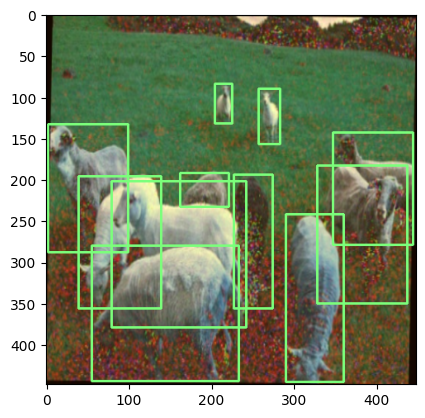

In [17]:
for idx, (image, labels, objects_num) in enumerate(dataset):
    img = np.array(image[0])
    labels = labels[0]
    n = objects_num[0]
    for i in range(n):
      label = labels[i]
      print(classes_name[int(label[4])])
      x, y = int(label[0]),int(label[1]) 
      w, h = int(label[2]), int(label[3])
      cv2.rectangle(img, (int(x-w/2), int(y-h/2)), (int(x+w/2), int(y+h/2)), (0, 255, 0), 2)
    plt.imshow((img - np.min(img))/255)
    break

In [17]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [18]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, '../pochu_version/ckpts/YOLO', max_to_keep=10,
                                     checkpoint_name='yolo')

In [20]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [19]:
from datetime import datetime
from tqdm import tqdm

In [34]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in tqdm(enumerate(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))    

2023-11-22 03:41:00.504023, start training.


0it [00:00, ?it/s]

2023-11-22 03:41:09.353488: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-11-22 03:41:09.353514: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-11-22 03:41:09.353529: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-11-22 03:41:09.353544: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas be

2023-11-22 04:03:34.887269, Epoch 1: loss 1.25
Saved checkpoint for epoch 16: ./ckpts/YOLO/yolo-16


4101it [20:38,  3.31it/s]


2023-11-22 04:24:14.517135, Epoch 2: loss 1.24
Saved checkpoint for epoch 17: ./ckpts/YOLO/yolo-17


4101it [21:37,  3.16it/s]


2023-11-22 04:45:53.188727, Epoch 3: loss 1.24
Saved checkpoint for epoch 18: ./ckpts/YOLO/yolo-18


4101it [21:34,  3.17it/s]


2023-11-22 05:07:28.166125, Epoch 4: loss 1.18
Saved checkpoint for epoch 19: ./ckpts/YOLO/yolo-19


4101it [20:48,  3.29it/s]


2023-11-22 05:28:17.423652, Epoch 5: loss 1.18
Saved checkpoint for epoch 20: ./ckpts/YOLO/yolo-20


In [20]:
def IOU(rect1, rect2):
    xmin1, ymin1, xmax1, ymax1 = rect1
    xmin2, ymin2, xmax2, ymax2 = rect2
    s1 = (xmax1 - xmin1) * (ymax1 - ymin1)
    s2 = (xmax2 - xmin2) * (ymax2 - ymin2)

    sum_area = s1 + s2

    left = max(xmin2, xmin1)
    right = min(xmax2, xmax1)
    top = max(ymin2, ymin1)
    bottom = min(ymax2, ymax1)

    if left >= right or top >= bottom:
        return 0

    intersection = (right - left) * (bottom - top)
    return intersection / (sum_area - intersection ) * 1.0

def process_outputs(outputs, confidence_threshold, iou_threshold):
    """
    Process YOLO outputs into bounding boxes
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    #max_conf = np.max(P)
    #index = np.argmax(P)

    xmin_l = []
    ymin_l = []
    xmax_l = []
    ymax_l = []
    class_num_l = []
    conf_l = []

    indexs = np.argsort(P.reshape(-1))[::-1][:]
    disabled = np.zeros(indexs.shape)
    
    for i, index in enumerate(indexs):
        if disabled[i]:
            continue
        index = np.unravel_index(index, P.shape)
        if P[index]<confidence_threshold and i != 0:
            break

        class_num = index[3]
        class_num_l.append(index[3])

        coordinate = np.reshape(coordinate, 
                                (CELL_SIZE, 
                                CELL_SIZE,
                                BOXES_PER_CELL, 
                                4))

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE

        xmin = xcenter - w/2.0
        ymin = ycenter - h/2.0

        xmax = xmin + w
        ymax = ymin + h

        xmin_l.append(xmin)
        ymin_l.append(ymin)
        xmax_l.append(xmax)
        ymax_l.append(ymax)
        class_num_l.append(class_num)
        conf_l.append(P[index])

        for j in range(i+1, len(indexs)):
            o_i = indexs[j]
            o_index = np.unravel_index(o_i, P.shape)
            o_class = o_index[3]
            if o_class != class_num:
                continue

            o_max_coordinate = coordinate[o_index[0], o_index[1], o_index[2], :]
            o_xcenter = o_max_coordinate[0]
            o_ycenter = o_max_coordinate[1]
            o_w = o_max_coordinate[2]
            o_h = o_max_coordinate[3]
            o_xcenter = (o_index[1] + o_xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
            o_ycenter = (o_index[0] + o_ycenter) * (IMAGE_SIZE/float(CELL_SIZE))
            o_w = o_w * IMAGE_SIZE
            o_h = o_h * IMAGE_SIZE
            o_xmin = o_xcenter - o_w/2.0
            o_ymin = o_ycenter - o_h/2.0
            o_xmax = o_xmin + o_w
            o_ymax = o_ymin + o_h
            if(IOU((xmin, ymin, xmax, ymax), (o_xmin, o_ymin, o_xmax, o_ymax)) > iou_threshold):
                disabled[j] = True

    return xmin_l, ymin_l, xmax_l, ymax_l, class_num_l, conf_l
    #return xmin, ymin, xmax, ymax, class_num, max_conf

In [21]:
#ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('../pochu_version/ckpts/YOLO/yolo-15')

In [22]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.keras.applications.resnet.preprocess_input(image)

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [23]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

In [24]:
import matplotlib.pyplot as plt
import cv2

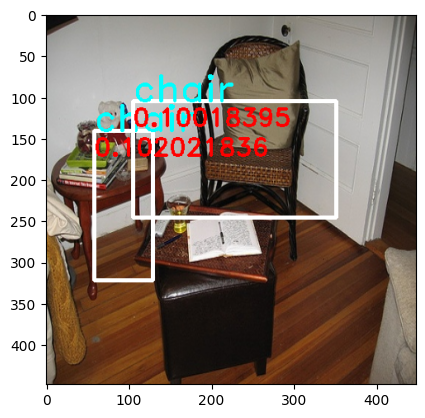

In [39]:
np_img = cv2.imread('./VOCdevkit_test/VOC2007/JPEGImages/000008.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = tf.keras.applications.resnet.preprocess_input(np_img)

np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred, 0.1, 0.5)

for i in range(len(xmin)):
    class_name = classes_name[class_num[i]]
    cv2.rectangle(resized_img, (int(xmin[i]), int(ymin[i])), (int(xmax[i]), int(ymax[i])), (255, 255, 255), 3)
    cv2.putText(resized_img, class_name, (int(xmin[i]), int(ymin[i])), 2, 1.5, (0, 255, 255), 2)
    cv2.putText(resized_img, str(conf[i]), (int(xmin[i]), int(ymin[i]+30)), 2, 1, (255, 0, 0), 2)
plt.imshow(resized_img)
plt.show()

In [25]:
import sys

sys.path.insert(0, './evaluate')
import evaluate
import pandas as pd

In [26]:
output_file = open('./test_prediction_v2.txt', 'w')
for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        # xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        # xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
        # output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii'))
        xmin_l, ymin_l, xmax_l, ymax_l, class_num_l, conf_l = process_outputs(prediction_step(test_img[i:i+1]), 0.001, 0.42)
        for j in range(len(xmin_l)):
            class_num = class_num_l[j] 
            conf = conf_l[j]
            xmin, ymin, xmax, ymax = xmin_l[j]*(img_w[i:i+1]/IMAGE_SIZE), ymin_l[j]*(img_h[i:i+1]/IMAGE_SIZE), xmax_l[j]*(img_w[i:i+1]/IMAGE_SIZE), ymax_l[j]*(img_h[i:i+1]/IMAGE_SIZE)
            output_file.write(" %d %d %d %d %d %f" %(xmin, ymin, xmax, ymax, class_num, conf))
        output_file.write("\n")

output_file.close()

evaluate.evaluate('./test_prediction_v2.txt', './output_file_0.001_0.42.csv')
cap = pd.read_csv('./output_fileoutput_file_0.001_0.42.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

2023-11-23 19:06:04.417631: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-11-23 19:06:04.419477: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000810000 Hz
2023-11-23 19:06:05.812535: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-11-23 19:06:06.034344: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-11-23 19:06:06.036958: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


End Evalutation


FileNotFoundError: [Errno 2] No such file or directory: './output_fileoutput_file_0.001_0.42.csv'